In [1]:
# Import packages
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

import nltk
from nltk.corpus import stopwords 
# from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

from gensim.models import KeyedVectors
from gensim.test.utils import datapath, get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec

import torch
from torch import nn

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
CUDA_flag = torch.cuda.is_available() # a flag to check if CUDA is available for GPU use
CUDA_flag

True

In [3]:
# Setup some variables
tknzr = TweetTokenizer()
# stemmer = PorterStemmer()
nltk.download('punkt')
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fonta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fonta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


----------------------------------------------------------------------

## Declaring some functions

In [4]:
# função de limpar texto
def cleanText(words, stem=False):
  """
    Esta função recebe um text e retorna o mesmo, já tratado com stopwords & punctuation
  """
  newWords = list()
  for word in words:
    word = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', word)
    word = re.sub("(@[A-Za-z0-9_]+)","", word)
    word = word.lower()
    if len(word) > 0 and word not in string.punctuation and word not in stopwords and word != "<br />":
      if stem:
        word = stemmer.stem(word)
        newWords.append(word)
      else:
        newWords.append(word)
  return newWords

In [5]:
# confusion matrix daora
def plot_conf_mat(y_test, y_preds, norm="false"):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds, normalize=norm),
                    annot=True,
                    cbar=False)
    plt.xlabel("True label")
    plt.ylabel("Predicted label")

In [6]:
def plot_loss_and_accuracy(losses, accs):

  fig, ax_tuple = plt.subplots(1, 2, figsize=(16,6))
  fig.suptitle('Loss and accuracy')

  for i, (y_label, y_values) in enumerate(zip(['BCE loss','Accuracy'],[losses, accs])):
    ax_tuple[i].plot(range(len(y_values)),  y_values, label='train')
    ax_tuple[i].set_xlabel('epochs')
    ax_tuple[i].set_ylabel(y_label)
    ax_tuple[i].legend()

In [7]:
def label2Embedding(word):
  ''' Recebe uma string (word) e devolve o embedding vector correspondente (se existir).
  '''
  if word in modelo.vocab:
    embed = modelo.get_vector(word)
    if embed is not None:
      return embed

-------------------------------------------------------------------------------

### Importando o arquivo do GloVE de 50 dimensões e criando a variável *modelo* que será por onde iremos interagir com o *word embedding* já treinado

In [8]:
cwd = os.getcwd()
cwd

'd:\\Dropbox\\GitHub\\2020_INF425_NLP_SeReS\\eda\\exercises'

In [9]:
num_dims = 100

glove_file = datapath(cwd+f'/../data/glove.6B.{num_dims}d.txt')
tmp_file   = get_tmpfile(cwd+f"/../data/glove.6B.{num_dims}d_word2vec.txt")
_          = glove2word2vec(glove_file, tmp_file)

filename_txt = cwd+f"/../data/glove.6B.{num_dims}d_word2vec.txt"
modelo = KeyedVectors.load_word2vec_format(filename_txt)

### Lendo o dataset

In [10]:
df = pd.read_csv("../data/data.csv", encoding = "utf-8")
df.head()

,Sl no,Tweets,Search key,Feeling
0,1,"#1: @fe ed ""RT @MirayaDizon1: Time is ticking...",happy moments,happy
1,2,"#2: @蓮花 &はすか ed ""RT @ninjaryugo: ＃コナモンの日 だそうで...",happy moments,happy
2,3,"#3: @Ris ♡ ed ""Happy birthday to one smokin h...",happy moments,happy
3,4,"#4: @월월 [씍쯴사랑로봇] jwinnie is the best, cheer u...",happy moments,happy
4,5,"#5: @Madhurima wth u vc♥ ed ""Good morning dea...",happy moments,happy


### Copiando o dataset e fazendo transformações necessárias

In [11]:
dataset = df.copy()

dataset = dataset.drop(columns=["Sl no", "Search key"])
dataset.head()

,Tweets,Feeling
0,"#1: @fe ed ""RT @MirayaDizon1: Time is ticking...",happy
1,"#2: @蓮花 &はすか ed ""RT @ninjaryugo: ＃コナモンの日 だそうで...",happy
2,"#3: @Ris ♡ ed ""Happy birthday to one smokin h...",happy
3,"#4: @월월 [씍쯴사랑로봇] jwinnie is the best, cheer u...",happy
4,"#5: @Madhurima wth u vc♥ ed ""Good morning dea...",happy


In [12]:
dataset['Feeling'].value_counts(normalize=True)*100

happy       39.213337
sad         28.441649
angry       13.387242
fear         8.615354
disgust      6.359189
surprise     3.983229
Name: Feeling, dtype: float64

In [13]:
# CONCATENAR COM O OUTRO DATASET

### Criando uma categoria com o *pd.Categorical* para cada emoção na tabela de emoções, dessa forma, teremos algo do tipo: happy - 1 | angry - 2 | sad = 3

Aplicando essas categorias na coluna *emotion_code*

In [14]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10017 entries, 0 to 10016
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Tweets   10017 non-null  object
 1   Feeling  10017 non-null  object
dtypes: object(2)
memory usage: 156.6+ KB


In [15]:
dataset['Feeling'] = pd.Categorical(dataset['Feeling'])
dataset['emotion_code'] = dataset['Feeling'].cat.codes
dataset.head()

,Tweets,Feeling,emotion_code
0,"#1: @fe ed ""RT @MirayaDizon1: Time is ticking...",happy,3
1,"#2: @蓮花 &はすか ed ""RT @ninjaryugo: ＃コナモンの日 だそうで...",happy,3
2,"#3: @Ris ♡ ed ""Happy birthday to one smokin h...",happy,3
3,"#4: @월월 [씍쯴사랑로봇] jwinnie is the best, cheer u...",happy,3
4,"#5: @Madhurima wth u vc♥ ed ""Good morning dea...",happy,3


In [16]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10017 entries, 0 to 10016
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Tweets        10017 non-null  object  
 1   Feeling       10017 non-null  category
 2   emotion_code  10017 non-null  int8    
dtypes: category(1), int8(1), object(1)
memory usage: 98.2+ KB


In [17]:
dataset[['Feeling','emotion_code']].value_counts().sort_index()


Feeling   emotion_code
angry     0               1341
disgust   1                637
fear      2                863
happy     3               3928
sad       4               2849
surprise  5                399
dtype: int64

In [18]:
type(dataset['Tweets'][0])

str

### Tokenizando os tweets com o *tknzr.tokenize*, e logo após, limpando os tokens com a função *cleanText*

In [19]:
dataset["CleanText"] = [tknzr.tokenize(sentence) for sentence in dataset["Tweets"]]
dataset["CleanText"] = [cleanText(sentence) for sentence in dataset["CleanText"]]
dataset.head()

,Tweets,Feeling,emotion_code,CleanText
0,"#1: @fe ed ""RT @MirayaDizon1: Time is ticking...",happy,3,"[1, ed, rt, time, ticking, fast, relive, past,..."
1,"#2: @蓮花 &はすか ed ""RT @ninjaryugo: ＃コナモンの日 だそうで...",happy,3,"[2, @蓮花, はすか, ed, rt, ＃, コナモンの日, だそうで, 、, コナモン..."
2,"#3: @Ris ♡ ed ""Happy birthday to one smokin h...",happy,3,"[3, ♡, ed, happy, birthday, one, smokin, hot, ..."
3,"#4: @월월 [씍쯴사랑로봇] jwinnie is the best, cheer u...",happy,3,"[4, @월월, 씍쯴사랑로봇, jwinnie, best, cheer, jwinnie..."
4,"#5: @Madhurima wth u vc♥ ed ""Good morning dea...",happy,3,"[5, wth, u, vc, ♥, ed, good, morning, dear, ❤,..."


In [20]:
# dataset['CleanText'][50]

### Conversão dos textos em uma sequência de índices (correspondente ao token do texto)

Limitar o tamanho máximo de um texto com ***max_len*** (truncar mensagem) e completar com <PAD> todos os textos que não cumprirem esse tamanho, para então termos variáveis do mesmo tamanho

In [21]:
max_len = 150        # comprimento máximo da mensagem (em número de palavras)
encoded_docs = []    # inicializa a lista de documentos codificados

for sentence in dataset['CleanText']: # para cada token
  encoded_d = [label2Embedding(t) for t in sentence]
  encoded_d = [vec.tolist() for vec in encoded_d if vec is not None]

  # adiciona o padding, se necessário
  padding_word_vecs = [np.zeros(num_dims).tolist()]*max(0, max_len-len(encoded_d)) 
  encoded_d = padding_word_vecs + encoded_d
  
  # trunca o documento e salva na lista de documentos codificados
  encoded_docs.append(encoded_d[:max_len]) 


encoded_docs_arrays = [np.vstack(sentence) for sentence in encoded_docs]

In [22]:
type(encoded_docs_arrays), type(encoded_docs_arrays[0]), encoded_docs_arrays[0].shape

(list, numpy.ndarray, (150, 100))

### Agora os textos são os documentos codificados

In [23]:
dataset['X'] = pd.Series(encoded_docs_arrays)
dataset['X'].tail() #.iloc[-1].shape

10012    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
10013    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
10014    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
10015    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
10016    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: X, dtype: object

### Verificando um exemplo de uma frase codificada

In [24]:
dataset['X'][0].shape, dataset['X'][0].dtype

((150, 100), dtype('float64'))

In [25]:
msg_codificada_ex = dataset['X'].iloc[7]
print(f' Mensagem codificada {msg_codificada_ex} \n Comprimento: {msg_codificada_ex.shape[0]} Dimensões: {msg_codificada_ex.shape[1]}')

 Mensagem codificada [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [-0.19327     0.52160001 -0.22936    ...  0.90416998  0.73799998
   0.72762001]
 [-0.20362     0.18005     0.38497001 ...  0.19208001 -0.14366999
   0.29043999]
 [-0.026284    0.017938   -0.50164998 ... -0.86879998  0.94094002
  -0.28815001]] 
 Comprimento: 150 Dimensões: 100


### Agora, usaremos apenas as mensagens codificadas (vetores de variáveis categóricas, coluna do DataFrame 'X') e as saídas rotuladas em  das emoções  (coluna 'y' do DataFrame). Também vamos converter os objetos para arrays do numpy.

In [26]:
X = np.dstack(dataset['X'].values).transpose(2,0,1)
Y = dataset['emotion_code'].values.reshape(-1,1)
X.shape, X[0].shape, Y.shape, Y[0].shape

((10017, 150, 100), (150, 100), (10017, 1), (1,))

### Separando com train_test_split

In [27]:
train_size = 0.8    # percentual de exemplos para o treino

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,                       # dataset para ser dividido, entrada X e saída Y
                                                    train_size=train_size,     # percentual resevado para o treinamento
                                                    stratify=Y,                # estratificação para manter a distribuição dos rótulos igual entre treino e teste
                                                    shuffle=True)              # embaralhar os exemplos aleatoriamente

X_train.shape, X_test.shape

((8013, 150, 100), (2004, 150, 100))

### Criando o modelo classificador

In [28]:

class Torch_Mean_Layer(nn.Module):
  '''Camada personalizada: calcula a média do tensor dentrada sobre a dimensão 1 (colunas).
     Retorna um vetor linha, onde cada elemento é a média dos elementos da coluna correspondente do tensor de entrada.
  '''
  def forward(self, x, dim=1):
    # print("-----------------------",x)
    x = torch.mean(x, dim=dim, keepdims=True)
    return x

class moodClassifier(nn.Module):
  '''Modelo classificador de emoções
  '''

  # ----------------------------------------------#
  # Método construtor
  def __init__(self, dim_embed, n_units): 
    super().__init__()  

    embedding_seq = [] # 
    ann_seq       = [] # 
    soft_seq      = []

    #---------------------------------------------------------------#
    # Embedding step: sequência de operações para converter X --> h
    embedding_seq.append(Torch_Mean_Layer())
    #---------------------------------------------------------------#

    #--------------------------------------------------------------------------#
    # ANN: Rede Neural Artifical Tradicional, com regressão logística na saída
    ann_seq.append(nn.Linear(dim_embed, n_units))
    ann_seq.append(nn.ReLU(inplace=True))
    ann_seq.append(nn.Linear(n_units, 6))
    
    #--------------------------------------------------------------------------#
    # Softmax :)
    soft_seq.append(nn.LogSoftmax(dim=1))

    #--------------------------------------------------------------------------#

    #--------------------------------------------------------------------------#
    # "merge" de todas as camamadas em uma layer sequencial 
    # (uma sequência para cada etapa)
    self.embedding = nn.Sequential(*embedding_seq)     # etapa de embedding 
    self.ann       = nn.Sequential(*ann_seq)           # etapa ANN
    self.soft      = nn.Sequential(*soft_seq)
    #--------------------------------------------------------------------------#


  def forward(self, x): 
    '''Processamento realizado ao chamar y=modelo(x)
    '''
    x = self.embedding(x)  # aplica a etapa de embedding
    x = self.ann(x)        # passa o embedding médio pelas camadas da ANN
    x = x.view(-1,6)
    x = self.soft(x)
    return x  

### Função que irá treinar 

In [29]:
def train_loop(model, data, max_epochs = 1000, print_iters = 5):
  X_train, Y_train = data # desempacotamento de tupla

  if CUDA_flag: # usar GPU?
      X_train = X_train.cuda()
      Y_train = Y_train.cuda()

  losses = []
  accs = []
  for i in range(max_epochs): # para cada época

      #-----------------------------------#
      # INÍCIO DO WORKFLOW DO TREINAMENTO #
      # 
      Y_pred = model.forward(X_train)         # apresente os dados de entrada para o modelo, e obtenha a previsão    
      loss = criterion(Y_pred.view(-1, 6), Y_train.view(-1))       # calcule a perda (o custo, o erro)
      optimizer.zero_grad()                   # inicialize os gradientes
      loss.backward()                         # backpropagation sobre a perda atual (cálculo dos novos gradientes) 
      optimizer.step()                        # atualização dos parâmetros da rede utilizando a regra do otimizador escolhido
      # FIM DO WORKFLOW DO TREINAMENTO    #
      #-----------------------------------#

      # ------ Bloco Opcional ------ #
      # Salvando métricas
      losses.append(loss)                     # salvando a perda atual
      acc = calc_accuracy(Y_pred, Y_train)     # calcula a taxa de acerto atual
      accs.append(acc)


      # INSERIR UM ACOMPANHAMENTO DA ACC DO TESTE
      
      # Imprimindo resultados parciais
      if i % print_iters ==0: # a cada 10 iterações
        print(f'epoch: {i:2}  loss: {loss.item():10.8f}') 
      #-----------------------------------#

  #----------------------------------------------------------------------------# 
  print('\n# Finished training!')
  print(f'# --> epoch: {i}  \n# --> initial loss: {losses[0]:10.8f} ,  \n# --> accuracy: {acc:2.8f} , \n# --> final loss: {losses[-1]:10.8f}')
  
  # retornando resultados
  return model, losses, accs

# Redefinindo cálculo da taxa de acerto 
def calc_accuracy(y_pred, y_true):
  ''' Helper function para calcular a taxa de acerto deste exemplo.
  '''
  y_pred = torch.argmax(y_pred, dim=1)
  y_pred = y_pred.float()
  y_true = torch.squeeze(y_true) # tentar rexplicar dps
  y_pred = torch.squeeze(y_pred)
  num_hits  = torch.sum(y_pred==y_true).cpu().numpy()
  num_total =  float(y_true.numel())
  acc=  num_hits/num_total
  return acc

### Treinando com o modelo

Convertendo os dados para tensores, instanciar o modelo, definir a função custo e o otimizador

In [30]:
data_train = (torch.FloatTensor(X_train), torch.LongTensor(Y_train))

Model = moodClassifier(dim_embed=num_dims, n_units=500)
if CUDA_flag:         # se houver GPUs disponíveis
  Model.cuda()       # converte o modelo para CUDA

print(Model)

criterion = nn.NLLLoss() # cross entropy loss
optimizer = torch.optim.Adam(Model.parameters(), lr = 0.001) 

Model, losses, accs = train_loop(Model, data_train, max_epochs=5000, print_iters=1) # note que o modelo é sobrescrito pela saída treinada

324
epoch: 4338  loss: 0.09667332
epoch: 4339  loss: 0.09663309
epoch: 4340  loss: 0.09659249
epoch: 4341  loss: 0.09655046
epoch: 4342  loss: 0.09651082
epoch: 4343  loss: 0.09647101
epoch: 4344  loss: 0.09643126
epoch: 4345  loss: 0.09639278
epoch: 4346  loss: 0.09635334
epoch: 4347  loss: 0.09631518
epoch: 4348  loss: 0.09627648
epoch: 4349  loss: 0.09623825
epoch: 4350  loss: 0.09620294
epoch: 4351  loss: 0.09616771
epoch: 4352  loss: 0.09613265
epoch: 4353  loss: 0.09609552
epoch: 4354  loss: 0.09605600
epoch: 4355  loss: 0.09601487
epoch: 4356  loss: 0.09597188
epoch: 4357  loss: 0.09593019
epoch: 4358  loss: 0.09588960
epoch: 4359  loss: 0.09584961
epoch: 4360  loss: 0.09581215
epoch: 4361  loss: 0.09577469
epoch: 4362  loss: 0.09573752
epoch: 4363  loss: 0.09570199
epoch: 4364  loss: 0.09566487
epoch: 4365  loss: 0.09562729
epoch: 4366  loss: 0.09558903
epoch: 4367  loss: 0.09554829
epoch: 4368  loss: 0.09550899
epoch: 4369  loss: 0.09546862
epoch: 4370  loss: 0.09542938
epoch:

In [31]:
# Rodando o Modelo treinado com o Dataset de Teste
data_test = (torch.FloatTensor(X_test), torch.LongTensor(Y_test))
X_test_tensor, Y_test_tensor = data_test

if CUDA_flag: # usar GPU?
      X_test_tensor = X_test_tensor.cuda()

Y_pred_tensor = Model.forward(X_test_tensor) 

# hard-decision e pós-processamento da saída 
y_pred = torch.argmax(Y_pred_tensor, dim=1)
y_pred = y_pred.float()
y_true = torch.squeeze(Y_test_tensor) 
y_pred = torch.squeeze(y_pred)

### Mostrando a *Confusion Matrix*

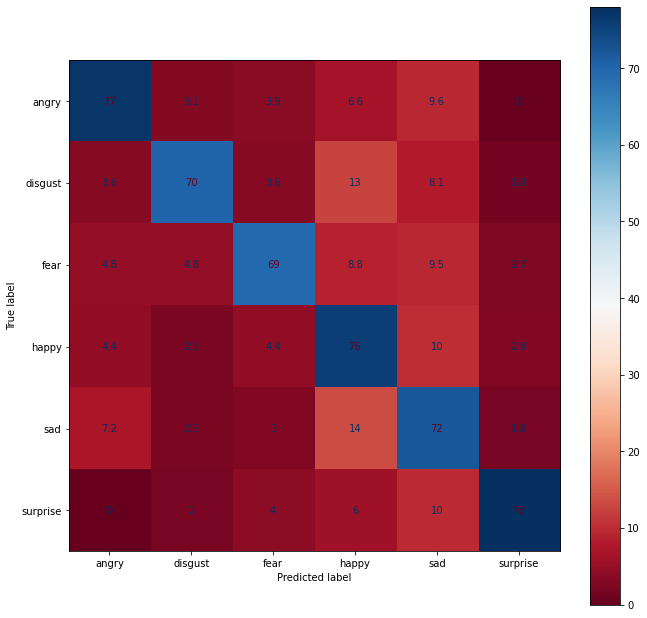

In [32]:
# sns.set(font_scale=1.5)
fig, ax = plt.subplots(1,1,figsize=(11,11))

cat_dict = dict( enumerate(dataset['Feeling'].cat.categories ) )

y_pred_cats = [cat_dict[i] for i in y_pred.cpu().numpy().tolist()]
y_true_cats = [cat_dict[i] for i in y_true.cpu().numpy().tolist()]

matriz_de_confusao = 100*confusion_matrix(y_pred_cats, y_true_cats, normalize='true', labels=list(cat_dict.values()))
# normalize{‘true’, ‘pred’, ‘all’}, default=None
# Normalizes confusion matrix over the true (rows), predicted (columns) conditions or all the population. If None, confusion matrix will not be normalized.

#criando list com as emoções
emotion_class = ['Angry','Disgust','Fear','Happy','Sad','Surprise']

df_matriz_de_confusao = pd.DataFrame(matriz_de_confusao, emotion_class, emotion_class)

cfm = ConfusionMatrixDisplay(matriz_de_confusao)

cfm.plot(ax=ax, cmap='RdBu')

ax.set_xticklabels(labels=list(cat_dict.values()))
ax.set_yticklabels(labels=list(cat_dict.values()))

ax.grid(False)

In [33]:
# matriz_de_confusao

In [34]:
accs[-1]

0.975789342318732

In [35]:
test_acc = calc_accuracy(Y_pred_tensor.cpu(), y_true.cpu())     # calcula a taxa de acerto atual
print(f'{100*test_acc:.2f}%')

74.10%


### Gráfico de *loss* e *accuracy*

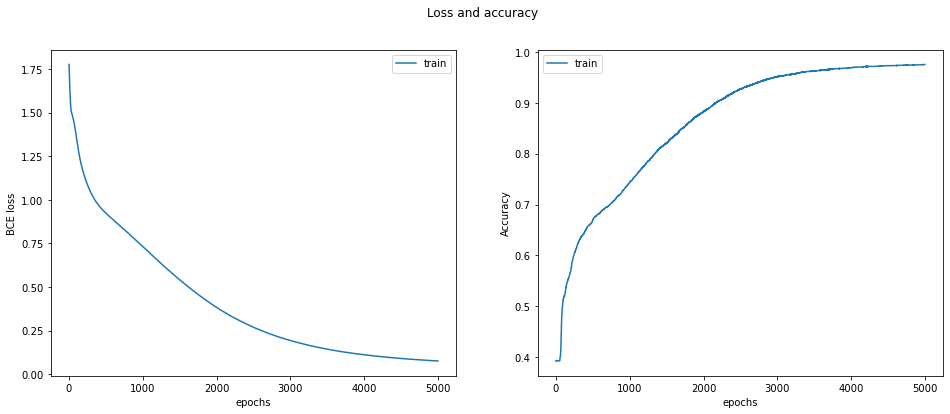

In [36]:
plot_loss_and_accuracy(losses, accs)

#### Salvando o modelo

In [37]:
torch.save(Model, cwd+"/../../models/emotions_classifier.pth")

#### Salvando o dict

In [38]:
torch.save(Model.state_dict(), cwd+"/../../dicts/emotions_classifier_dict")

In [39]:
model = torch.load(cwd+"/../../models/emotions_classifier.pth")
model.eval()

moodClassifier(
  (embedding): Sequential(
    (0): Torch_Mean_Layer()
  )
  (ann): Sequential(
    (0): Linear(in_features=100, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=6, bias=True)
  )
  (soft): Sequential(
    (0): LogSoftmax(dim=1)
  )
)

In [40]:
input_size  = 3 # tamanho do embedding: número de dimensões da entrada
hidden_size = 5 # arbitrário: número de dimensões da saída da camada
num_layers  = 1 # número de LSTMs em cascata 
# (cada saída h_t de uma hidden-layer é uma entrada na próxima camada, para t = 2, ... , seq_len)

lstm = nn.LSTM(input_size=input_size,
               hidden_size=hidden_size, 
               num_layers=num_layers, 
               batch_first=True) # primeira dimensão é o tamanho da batch (num. de exemplos)
lstm

LSTM(3, 5, batch_first=True)

In [41]:
seq_len = 10   # tamanho da sequência
batch_size = 2 # num. de exemplos 

x  = torch.randn( size = (batch_size, seq_len, input_size) ) # 1 exemplo com 10 vetores de 3 dims.
h0 = torch.zeros( size = (num_layers, batch_size, hidden_size) ) # hidden-state inicial de cada ex
c0 = torch.zeros( size = (num_layers, batch_size, hidden_size) ) # cell-state inicial de cada ex

print(x.shape, 
      h0.shape, 
      c0.shape, end=2*'\n')
print(*[x,h0,c0], sep='\n')

torch.Size([2, 10, 3]) torch.Size([1, 2, 5]) torch.Size([1, 2, 5])

tensor([[[-0.1357,  1.5635, -0.2681],
         [ 0.3040, -0.6824, -0.6212],
         [-1.2098,  0.5869,  0.2462],
         [ 1.3038,  0.1025, -0.9759],
         [-0.3976,  1.0544,  0.6244],
         [ 1.1182,  0.7386, -0.7173],
         [-0.3684,  0.5446,  0.9168],
         [-0.7652,  0.4203,  0.0629],
         [-0.6541,  0.1509,  1.6619],
         [ 0.1490,  0.5265, -0.0233]],

        [[ 0.2093, -0.8682, -0.2156],
         [ 1.0075, -0.1843, -0.8041],
         [ 0.7094,  0.2445, -1.6516],
         [-0.3902, -0.4557,  0.3327],
         [ 0.4388,  1.4196,  1.5332],
         [-0.6849, -1.3821,  1.0165],
         [ 0.4395,  0.3294,  0.9789],
         [ 1.6332,  0.4142,  0.7212],
         [-1.4107, -0.0602,  2.2209],
         [-0.3681, -0.5372,  0.8070]]])
tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]])
tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]])


In [42]:
y, (h_n, c_n) = lstm(x, (h0,c0))

In [43]:
print(y.shape, h_n.shape, c_n.shape)

torch.Size([2, 10, 5]) torch.Size([1, 2, 5]) torch.Size([1, 2, 5])


In [44]:
print(*[y, h_n, c_n], sep='\n')

tensor([[[ 0.0810,  0.0305, -0.0418,  0.1029,  0.0525],
         [ 0.0081, -0.1386,  0.0628,  0.1213,  0.1562],
         [-0.0175, -0.0449, -0.0146,  0.1221,  0.0673],
         [ 0.0374, -0.1290,  0.0873,  0.1239,  0.2678],
         [ 0.0079, -0.0806,  0.0569,  0.1423,  0.1485],
         [ 0.1173, -0.1033,  0.1060,  0.1361,  0.2601],
         [-0.0067, -0.1264,  0.1087,  0.1416,  0.1589],
         [-0.0292, -0.0732,  0.0485,  0.1293,  0.1052],
         [-0.0980, -0.1068,  0.0603,  0.0904,  0.1233],
         [-0.1245, -0.0967,  0.0690,  0.1134,  0.1905]],

        [[-0.1535, -0.1708,  0.1037,  0.0416,  0.1392],
         [-0.1628, -0.1720,  0.1615,  0.1015,  0.2528],
         [-0.0171, -0.1438,  0.1157,  0.1442,  0.1502],
         [-0.1271, -0.2668,  0.1210,  0.1571,  0.1272],
         [-0.0605, -0.0960,  0.1173,  0.1253,  0.2143],
         [-0.2473, -0.2584,  0.1960,  0.1004,  0.1275],
         [-0.2212, -0.1698,  0.1937,  0.1049,  0.2491],
         [-0.2729, -0.1826,  0.2659,  0.1192, 

In [45]:
h_n.transpose(1,0).shape

torch.Size([2, 1, 5])

In [46]:
class moodClassifierWithLasersOnSteroids(nn.Module):
  '''Modelo classificador de emoções com LSTMs.
  '''

  # ----------------------------------------------#
  # Método construtor
  def __init__(self, dim_embed, n_units_lstm, n_units_linear): 
    super().__init__()  

    embedding_seq = [] # 
    ann_seq       = [] # 
    soft_seq      = []

    #---------------------------------------------------------------#
    # Embedding step: sequência de operações para converter X --> h
    embedding_seq.append(nn.LSTM(input_size=dim_embed,
                                  hidden_size=n_units_lstm, 
                                  num_layers=1,
                                  batch_first=True))
    #---------------------------------------------------------------#

    #--------------------------------------------------------------------------#
    # ANN: Rede Neural Artifical Tradicional, com regressão logística na saída
    ann_seq.append(nn.Linear(n_units_lstm, n_units_linear))
    ann_seq.append(nn.ReLU(inplace=True))
    ann_seq.append(nn.Linear(n_units_linear, 6))
    
    #--------------------------------------------------------------------------#
    # Softmax :)
    soft_seq.append(nn.LogSoftmax(dim=1))

    #--------------------------------------------------------------------------#

    #--------------------------------------------------------------------------#
    # "merge" de todas as camamadas em uma layer sequencial 
    # (uma sequência para cada etapa)
    self.embedding = nn.Sequential(*embedding_seq)     # etapa de embedding 
    self.ann       = nn.Sequential(*ann_seq)           # etapa ANN
    self.soft      = nn.Sequential(*soft_seq)
    #--------------------------------------------------------------------------#


  def forward(self, x): 
    '''Processamento realizado ao chamar y=modelo(x)
    '''
    _, (x, _) = self.embedding(x)  # aplica a etapa de embedding
    x = x.transpose(1,0)   # inverte dimensões (força "batch first" no hidden state)
    x = self.ann(x)        # passa o embedding médio pelas camadas da ANN
    x = x.view(-1,6)
    x = self.soft(x)
    return x  

In [47]:
import gc
torch.cuda.empty_cache() #free up some memory
gc.collect()             #free up some memory

data_train = (torch.FloatTensor(X_train), torch.LongTensor(Y_train))

Model = moodClassifierWithLasersOnSteroids(dim_embed=num_dims, n_units_lstm=50, n_units_linear=50)
if CUDA_flag:         # se houver GPUs disponíveis
  Model.cuda()       # converte o modelo para CUDA
print(Model)

criterion = nn.NLLLoss() # cross entropy loss
optimizer = torch.optim.Adam(Model.parameters(), lr = 0.001) 

Model, losses, accs = train_loop(Model, data_train, max_epochs=2000, print_iters=1) # note que o modelo é sobrescrito pela saída treinada

432
epoch: 1338  loss: 0.05154763
epoch: 1339  loss: 0.05153096
epoch: 1340  loss: 0.05151436
epoch: 1341  loss: 0.05149780
epoch: 1342  loss: 0.05148128
epoch: 1343  loss: 0.05146480
epoch: 1344  loss: 0.05144840
epoch: 1345  loss: 0.05143203
epoch: 1346  loss: 0.05141571
epoch: 1347  loss: 0.05139944
epoch: 1348  loss: 0.05138319
epoch: 1349  loss: 0.05136703
epoch: 1350  loss: 0.05135090
epoch: 1351  loss: 0.05133480
epoch: 1352  loss: 0.05131875
epoch: 1353  loss: 0.05130273
epoch: 1354  loss: 0.05128678
epoch: 1355  loss: 0.05127086
epoch: 1356  loss: 0.05125501
epoch: 1357  loss: 0.05123918
epoch: 1358  loss: 0.05122338
epoch: 1359  loss: 0.05120764
epoch: 1360  loss: 0.05119196
epoch: 1361  loss: 0.05117631
epoch: 1362  loss: 0.05116073
epoch: 1363  loss: 0.05114518
epoch: 1364  loss: 0.05112966
epoch: 1365  loss: 0.05111420
epoch: 1366  loss: 0.05109877
epoch: 1367  loss: 0.05108337
epoch: 1368  loss: 0.05106805
epoch: 1369  loss: 0.05105271
epoch: 1370  loss: 0.05103745
epoch:

moodClassifierWithLasersOnSteroids(
  (embedding): Sequential(
    (0): LSTM(100, 50, batch_first=True)
  )
  (ann): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=50, out_features=6, bias=True)
  )
  (soft): Sequential(
    (0): LogSoftmax(dim=1)
  )
)
0.9791588668413828


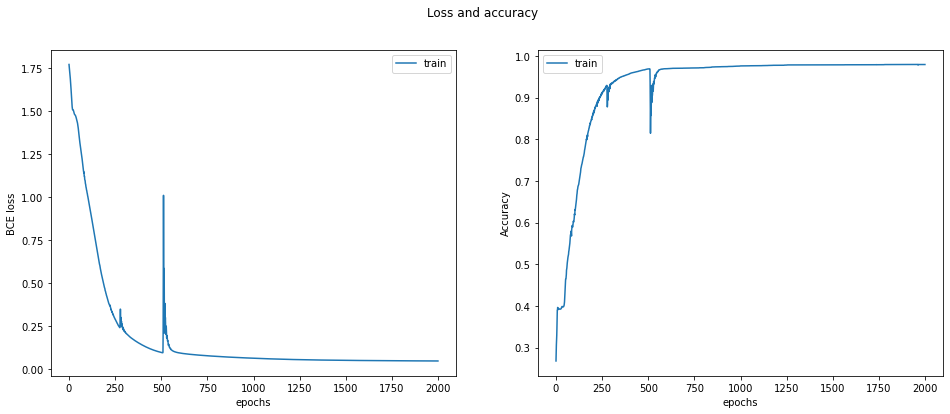

In [48]:
print(Model)
plot_loss_and_accuracy(losses, accs)
print(accs[-1])

In [49]:
# Rodando o Modelo treinado com o Dataset de Teste
data_test = (torch.FloatTensor(X_test), torch.LongTensor(Y_test))
X_test_tensor, Y_test_tensor = data_test

if CUDA_flag: # usar GPU?
      X_test_tensor = X_test_tensor.cuda()
      
Y_pred_tensor = Model.forward(X_test_tensor) 

# hard-decision e pós-processamento da saída
y_pred = torch.argmax(Y_pred_tensor, dim=1)
y_pred = y_pred.float()
y_true = torch.squeeze(Y_test_tensor) 
y_pred = torch.squeeze(y_pred)

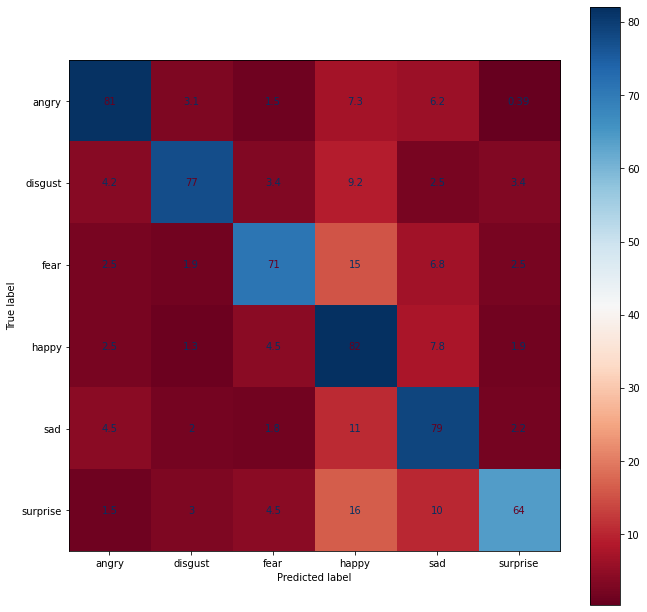

In [50]:
# sns.set(font_scale=1.5)
fig, ax = plt.subplots(1,1,figsize=(11,11))

cat_dict = dict( enumerate(dataset['Feeling'].cat.categories ) )

y_pred_cats = [cat_dict[i] for i in y_pred.cpu().numpy().tolist()]
y_true_cats = [cat_dict[i] for i in y_true.cpu().numpy().tolist()]

matriz_de_confusao = 100*confusion_matrix(y_pred_cats, y_true_cats, normalize='true', labels=list(cat_dict.values()))
# normalize{‘true’, ‘pred’, ‘all’}, default=None
# Normalizes confusion matrix over the true (rows), predicted (columns) conditions or all the population. If None, confusion matrix will not be normalized.

#criando list com as emoções
emotion_class = ['Angry','Disgust','Fear','Happy','Sad','Surprise']

df_matriz_de_confusao = pd.DataFrame(matriz_de_confusao, emotion_class, emotion_class)

cfm = ConfusionMatrixDisplay(matriz_de_confusao)

cfm.plot(ax=ax, cmap='RdBu')

ax.set_xticklabels(labels=list(cat_dict.values()))
ax.set_yticklabels(labels=list(cat_dict.values()))

ax.grid(False)

In [51]:
accs[-1]

0.9791588668413828

In [52]:
test_acc = calc_accuracy(Y_pred_tensor.cpu(), y_true.cpu())     # calcula a taxa de acerto atual
print(f'{100*test_acc:.2f}%')

79.19%
